In [44]:
import pandas as pd
import numpy as np
import gensim
import pickle
from gensim.models import Word2Vec
import pandas as pd
import nltk
import re
import glob
from gensim.models.phrases import Phrases, Phraser
import ahocorasick
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from sklearn.metrics import r2_score
from scipy.stats import spearmanr
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
import seaborn as sns;
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
C = ahocorasick.Automaton()
M = ahocorasick.Automaton()
def not_all_uppercase(str):
    for i in range(len(str)):
        if(str[i]>='a' and str[i]<='z'):
            return True
    return False

    
tot_cs=-1
tot_medical=-1
dict={}
last_conbine="hahhahahahahahahaha"
with open("top200cs_combine.txt") as f:
    for line in f:
        pos=line.strip().find(':')
        conbine=re.sub(r'_',' ',line.strip().lower()[pos+1:])
        if(conbine!=last_conbine):
            tot_cs+=1
        last_conbine=conbine
        C.add_word(re.sub(r'_',' ',line.strip().lower()[:pos]),tot_cs)
        dict[tot_cs]=line.strip().lower()[:pos]
        print(line.strip().lower()[:pos],"    ",conbine,"    ",tot_cs)

with open("top200medical_combine.txt") as f:
    for line in f:
        pos=line.strip().find(':')
        conbine=re.sub(r'_',' ',line.strip().lower()[pos+1:])
        if(conbine!=last_conbine):
            tot_medical+=1
        last_conbine=conbine
        M.add_word(re.sub(r'_',' ',line.strip().lower()[:pos]),tot_medical)
        dict[5000+tot_medical]=line.strip().lower()[:pos]

C.make_automaton()
M.make_automaton()




# df_all = pd.read_csv('./papers.csv')
df_all = pd.read_csv('./papers_2022.csv')

start=1
end=6
start_pred = 259
end_pred = start_pred+5
df_all['Date']=(df_all['year']-2000)*12+df_all['month']
print(tot_cs,"  ",tot_medical)
last_heat=np.zeros((tot_cs+100,tot_medical+100))
pred_heat=np.zeros((tot_cs+100,tot_medical+100))
train_data={}
train_label={}
test_data={}
test_label={}
for c in range(0,tot_cs+1):
    for m in range(0,tot_medical+1):
        train_data[c*10000+m]=[]
        train_label[c*10000+m]=[]
        test_data[c*10000+m]=[]
        test_label[c*10000+m]=[]
# while(end<=234):#2019-6
while(end<=end_pred):##2021-12
    print(start,"   ",end, len(train_label))
   # for c in range(1,tot_cs+1):
   #     for m in range(1,tot_medical+1):
   #         print(last_heat[c+20][m+20]," ")
    print("\n")
    df=df_all[ (df_all['Date']>=start) &(df_all['Date']<=end)]
    df = df.reset_index(drop=True)
    #display(df)
    maxn=0
    heat=np.zeros((tot_cs+100,tot_medical+100))
    for i in range(len(df)):
        #print(i)
        if(pd.isnull(df.loc[i]['abstract'])):
            continue
        str=df.loc[i]['abstract']
        medical_word=[]
        cs_word=[]
        for end_index, c in C.iter(df.loc[i]['abstract'].lower()):
            cs_word.append(c)
        for end_index, m in M.iter(df.loc[i]['abstract'].lower()):
            medical_word.append(m)
        for c in set(cs_word):
            for m in set(medical_word):
                heat[c+20,m+20]+=1
                if(heat[c+20,m+20]>maxn):
                    maxn=heat[c+20,m+20]
    #print(heat)
    if(start!=1):
        
        for c in range(0,tot_cs+1):
            for m in range(0,tot_medical+1):
                tmp=[start-6]
                for c1 in range(c-9,c+10):
                    for m1 in range(m-9,m+10):
                        tmp.append(last_heat[c1+20][m1+20])
                        
                # if(start>=229): # 2019-01
                if(start>=start_pred): # 2021-07
                    #print(train_data[c*10000+m])
                    #print(train_label[c*10000+m])
                    #print(tmp)
                    #print("---")

                    
                    reg = Ridge( random_state=0).fit(np.asarray(train_data[c*10000+m]), np.asarray(train_label[c*10000+m]))
                    pred_heat[c+20][m+20]=reg.predict(np.asarray([tmp]))[0]
                    
                    
                    if(pred_heat[c+20][m+20]<0):
                        pred_heat[c+20][m+20]=0
         
                else:
                    train_data[c*10000+m].append(tmp)
                    train_label[c*10000+m].append(heat[c+20,m+20])

    
    last_heat=heat
    start+=6
    end+=6

structural_features      structural features      0
structural_information      structural information      1
physicochemical_properties      physicochemical properties      2
computational_complexity      computational complexity      3
feature_space      feature space      4
feature_vector      feature vector      5
mutual_information      mutual information      6
external_validation      external validation      7
nearest_neighbor      nearest neighbor      8
standard_deviation      standard deviation      9
correlation_coefficient      correlation coefficient      10
time_series      time series      11
missing_data      missing data      12
prediction_model      prediction model      13
predictive_model      prediction model      13
predictive_modeling      prediction model      13
computational_models      computational models      14
computational_approaches      computational models      14
computational_methods      computational models      14
statistical_methods      statis

KeyboardInterrupt: 

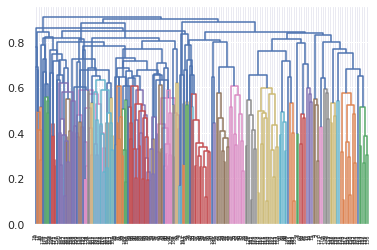

In [126]:
# model = Word2Vec.load("word2vec/fulltext_abstract_new.model")
row_dis=[]
col_dis=[]
for i in range(0,tot_cs+1):
    for j in range(i+1,tot_cs+1):
        row_dis.append(1-model.wv.similarity(dict[i],dict[j]))
        
for i in range(0,tot_medical+1):
    for j in range(i+1,tot_medical+1):
        col_dis.append(1-model.wv.similarity(dict[5000+i],dict[5000+j]))
row_linkage = hc.linkage(row_dis, method='average')
col_linkage= hc.linkage(col_dis, method='average')
row_order = hc.dendrogram(row_linkage)
col_order = hc.dendrogram(col_linkage)


In [123]:
help(ax.set_xticklabels)

Help on method set_xticklabels in module matplotlib.axes._base:

set_xticklabels(labels, *, fontdict=None, minor=False, **kwargs) method of matplotlib.axes._subplots.AxesSubplot instance
    Set the xaxis' labels with list of string labels.
    
    .. warning::
        This method should only be used after fixing the tick positions
        using `.Axes.set_xticks`. Otherwise, the labels may end up in
        unexpected positions.
    
    Parameters
    ----------
    labels : list of str
        The label texts.
    
    fontdict : dict, optional
        A dictionary controlling the appearance of the ticklabels.
        The default *fontdict* is::
    
           {'fontsize': rcParams['axes.titlesize'],
            'fontweight': rcParams['axes.titleweight'],
            'verticalalignment': 'baseline',
            'horizontalalignment': loc}
    
    minor : bool, default: False
        Whether to set the minor ticklabels rather than the major ones.
    
    Returns
    -------
    l

[Text(0.5, 0, 'brain_activity'),
 Text(1.5, 0, 'chronological_age'),
 Text(2.5, 0, 'gray_matter'),
 Text(3.5, 0, 'cortical_thickness'),
 Text(4.5, 0, 'white_matter'),
 Text(5.5, 0, 'computed_tomography'),
 Text(6.5, 0, 'age-related_macular_degeneration'),
 Text(7.5, 0, 'retrospective_study'),
 Text(8.5, 0, 'visual_field'),
 Text(9.5, 0, 'sleep_stages'),
 Text(10.5, 0, 'optic_disc'),
 Text(11.5, 0, 'optical_coherence_tomography'),
 Text(12.5, 0, 'diabetic_retinopathy'),
 Text(13.5, 0, 'health_care'),
 Text(14.5, 0, 'environmental_factors'),
 Text(15.5, 0, 'quality_of_life'),
 Text(16.5, 0, 'clinical_trial'),
 Text(17.5, 0, 'physical_activity'),
 Text(18.5, 0, 'activities_of_daily_living'),
 Text(19.5, 0, 'systematic_review'),
 Text(20.5, 0, 'cohort_study'),
 Text(21.5, 0, 'primary_care'),
 Text(22.5, 0, 'mental_health'),
 Text(23.5, 0, 'public_health'),
 Text(24.5, 0, 'the_elderly'),
 Text(25.5, 0, 'clinical_diagnosis'),
 Text(26.5, 0, 'patient_safety'),
 Text(27.5, 0, 'patient_care'),


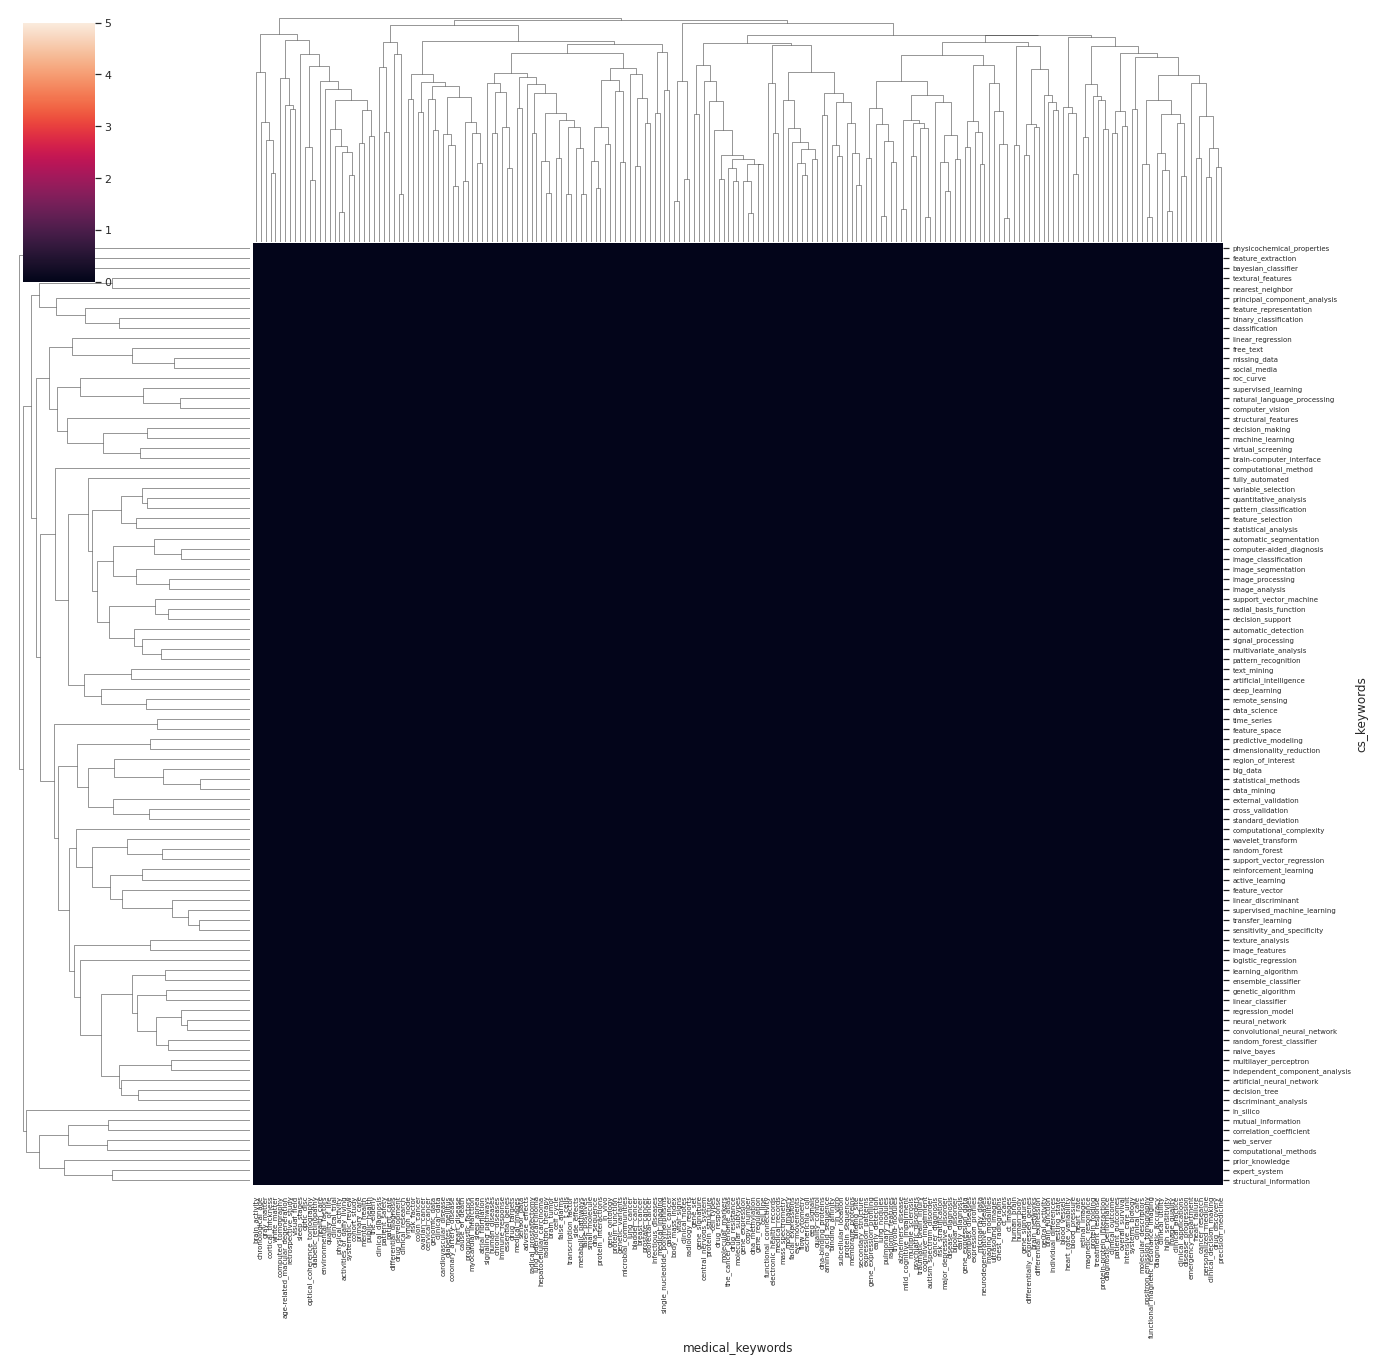

In [139]:
plot_heat=np.zeros((tot_cs+1,tot_medical+1))
g=sns.clustermap(plot_heat, figsize=(20, 20), row_linkage=row_linkage, col_linkage=col_linkage, vmin=0, vmax=5,\
    yticklabels = [dict[r] for r in row_order['leaves']], xticklabels = [dict[5000 + c] for c in col_order['leaves']]) 
    # xticklabels = [r for r in row_order['leaves']], yticklabels = [c for c in col_order['leaves']])
ax = g.ax_heatmap
ax.set_ylabel("cs_keywords")
ax.set_xlabel("medical_keywords")

ax.set_yticklabels(ax.get_ymajorticklabels(), fontdict={'fontsize':7})
ax.set_xticklabels(ax.get_xmajorticklabels(), fontdict={'fontsize':7})


## heatmap_prediction_all_by_real_sample_from_2010

In [28]:
from curses import window
import pandas as pd
import numpy as np
import gensim
import pickle
from gensim.models import Word2Vec
import pandas as pd
import nltk
import re
import glob
from gensim.models.phrases import Phrases, Phraser
import ahocorasick
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from sklearn.metrics import r2_score
from scipy.stats import spearmanr
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
C = ahocorasick.Automaton()
M = ahocorasick.Automaton()
def not_all_uppercase(str):
    for i in range(len(str)):
        if(str[i]>='a' and str[i]<='z'):
            return True
    return False

tot_cs=-1
tot_medical=-1
dict={}
last_conbine="hahhahahahahahahaha"
with open("cs1000_combine.txt") as f:
    for line in f:
        pos=line.strip().find(':')
        conbine=re.sub(r'_',' ',line.strip().lower()[pos+1:])
        if(conbine!=last_conbine):
            tot_cs+=1
        last_conbine=conbine
        C.add_word(re.sub(r'_',' ',line.strip().lower()[:pos]),tot_cs)
        
        print(line.strip().lower()[:pos],"    ",conbine,"    ",tot_cs)

with open("medical1000_combine.txt") as f:
    for line in f:
        pos=line.strip().find(':')
        conbine=re.sub(r'_',' ',line.strip().lower()[pos+1:])
        if(conbine!=last_conbine):
            tot_medical+=1
        last_conbine=conbine
        M.add_word(re.sub(r'_',' ',line.strip().lower()[:pos]),tot_medical)

def get_r2(pred_heat,heat):
    y_true=[]
    y_pred=[]
    for c in range(1,tot_cs+1):
        for m in range(1,tot_medical+1):
            y_true.append(heat[c+20][m+20])
            y_pred.append(pred_heat[c+20][m+20])
    #print(y_true)
    #print(y_pred)

    #print("---------------------------------------")
    return r2_score(y_true, y_pred)
    
def get_spearmanr(pred_heat,heat):
    y_true=[]
    y_pred=[]
    for c in range(1,tot_cs+1):
        for m in range(1,tot_medical+1):
            y_true.append(heat[c+20][m+20])
            y_pred.append(pred_heat[c+20][m+20])
    #print(y_true)
    #print(y_pred)

    #print("---------------------------------------")
    return spearmanr(y_true, y_pred).correlation
C.make_automaton()
M.make_automaton()

df_all = pd.read_csv('./papers.csv')
# df_all = pd.read_csv('./papers_2022.csv')
start=1
end=6
df_all['Date']=(df_all['year']-2000)*12+df_all['month']
start=1
end=6
print(tot_cs,"  ",tot_medical)
last_heat=np.zeros((tot_cs+100,tot_medical+100))
pred_ridge_false=np.zeros((tot_cs+100,tot_medical+100))
pred_ridge_true=np.zeros((tot_cs+100,tot_medical+100))
pred_svr=np.zeros((tot_cs+100,tot_medical+100))
pred_lasso=np.zeros((tot_cs+100,tot_medical+100))

train_data={}
train_label={}
test_data={}
test_label={}
for c in range(1,tot_cs+1):
    for m in range(1,tot_medical+1):
        train_data[c*10000+m]=[]
        train_label[c*10000+m]=[]
        test_data[c*10000+m]=[]
        test_label[c*10000+m]=[]

results = {}
results['date'] = []

results['svr_r2'] = []
results['lasso_r2'] = []
results['ridge_false_r2'] = []
results['ridge_true_r2'] = []

# results['linear_regression_spearmanr'] = []
# results['svr_spearmanr'] = []
# results['lasso_spearmanr'] = []
# results['ridge_false_spearmanr'] = []
# results['ridge_true_spearmanr'] = []











remote_sensing      remote sensing      0
electronic_nose      electronic nose      1
sensor_array      sensor array      2
motion_capture      motion capture      3
inertial_measurement_unit      inertial measurement unit      4
gait_analysis      gait analysis      5
inertial_sensors      inertial sensors      6
surface_electromyography      surface electromyography      7
wearable_sensors      wearable sensors      8
wearable_device      wearable device      9
social_network      social network      10
social_media      social media      11
virtual_reality      virtual reality      12
augmented_reality      augmented reality      13
mobile_phones      mobile phones      14
mobile_devices      mobile devices      15
diffusion_tensor_imaging      diffusion tensor imaging      16
resting-state_fmri      resting-state fmri      17
structural_mri      structural mri      18
resting-state_functional_magnetic_resonance_imaging      resting-state functional magnetic resonance imaging      1

KeyboardInterrupt: 

In [3]:
import warnings

warnings.filterwarnings('ignore')

heats = {}
pred_ridge_false = {}
pred_ridge_true = {}
pred_svr = {}
pred_lasso = {}
start = 1
end = 6
while(end<=234):#2019-6
    date = "{}/{}".format(2000+int(start/12), start%12)
    
    df=df_all[ (df_all['Date']>=start) &(df_all['Date']<=end)]
    df = df.reset_index(drop=True)
    #display(df)

    heat = np.zeros((tot_cs+100,tot_medical+100))

    for i in range(len(df)):
        #print(i)
        if(pd.isnull(df.loc[i]['abstract'])):
            continue
        str=df.loc[i]['abstract']
        medical_word=[]
        cs_word=[]
        for end_index, c in C.iter(df.loc[i]['abstract'].lower()):
            cs_word.append(c)
        for end_index, m in M.iter(df.loc[i]['abstract'].lower()):
            medical_word.append(m)
        for c in set(cs_word):
            for m in set(medical_word):
                heat[c+20, m+20]+=1
    heats[date] = heat
    if start!=1:
        print(date, start)
        results['date'].append(date)
        pred_ridge_false[date]=np.zeros((tot_cs+100,tot_medical+100))
        pred_ridge_true[date]=np.zeros((tot_cs+100,tot_medical+100))
        pred_svr[date]=np.zeros((tot_cs+100,tot_medical+100))
        pred_lasso[date]=np.zeros((tot_cs+100,tot_medical+100))
    start += 6
    end += 6

2000/7 7
2001/1 13
2001/7 19
2002/1 25
2002/7 31
2003/1 37
2003/7 43
2004/1 49
2004/7 55
2005/1 61
2005/7 67
2006/1 73
2006/7 79
2007/1 85
2007/7 91
2008/1 97
2008/7 103
2009/1 109
2009/7 115
2010/1 121
2010/7 127
2011/1 133
2011/7 139
2012/1 145
2012/7 151
2013/1 157
2013/7 163
2014/1 169
2014/7 175
2015/1 181
2015/7 187
2016/1 193
2016/7 199
2017/1 205
2017/7 211
2018/1 217
2018/7 223
2019/1 229


In [4]:
window_size = 5
for cc in range(1,tot_cs+1):
    print(cc)
    for mm in range(1,tot_medical+1):
        train_data=[]
        train_label=[]
        start = 1
        end = 6
        while(end<=234):#2019-6
        # while(end<=264):#2021-12
            # print(start,"   ", end, len(train_label))
            date = "{}/{}".format(2000+int(start/12), start%12)
        # for c in range(1,tot_cs+1):
        #     for m in range(1,tot_medical+1):
        #         print(last_heat," ")
            heat = heats[date]

            #print(heat)
            if(start!=1):
                layers=window_size
                # for c in range(1,tot_cs+1):
                #     for m in range(1,tot_medical+1):
                tmp=[start-6] # why
                for c1 in range(cc-layers+1,cc+layers):
                    for m1 in range(m-layers+1,m+layers):
                        tmp.append(last_heat[c1+20, m1+20])
                        
                if(start>=30):
                    #print(train_data)
                    #print(train_label)
                    #print(tmp)
                    #print("---")
                    reg = Ridge(normalize=False,random_state=0).fit(np.asarray(train_data), np.asarray(train_label))
                    pred_ridge_false[date][cc+20, mm+20]=reg.predict(np.asarray([tmp]))[0]
                    if(pred_ridge_false[date][cc+20, mm+20]<0):
                        pred_ridge_false[date][cc+20, mm+20]=0
                    
                    
                    reg = Ridge(normalize=True,random_state=0).fit(np.asarray(train_data), np.asarray(train_label))
                    pred_ridge_true[date][cc+20, mm+20]=reg.predict(np.asarray([tmp]))[0]
                    if(pred_ridge_true[date][cc+20, mm+20]<0):
                        pred_ridge_true[date][cc+20, mm+20]=0
                        
                        
                    reg = Lasso(random_state=0).fit(np.asarray(train_data), np.asarray(train_label))
                    pred_lasso[date][cc+20, mm+20]=reg.predict(np.asarray([tmp]))[0]
                    if(pred_lasso[date][cc+20, mm+20]<0):
                        pred_lasso[date][cc+20, mm+20]=0
                        
                        
                        
                    reg = SVR().fit(np.asarray(train_data), np.asarray(train_label))
                    pred_svr[date][cc+20, mm+20]=reg.predict(np.asarray([tmp]))[0]
                    if(pred_svr[date][cc+20, mm+20]<0):
                        pred_svr[date][cc+20, mm+20]=0
                        

                        
                train_data.append(tmp)
                train_label.append(heat[cc+20, mm+20])

                # print(2000+int(start/12)," ",start%12,"  :\n")
                # print(get_r2(pred_lr,heat)," ", get_spearmanr(pred_lr,heat))
                # print(get_r2(pred_svr,heat)," ", get_spearmanr(pred_svr,heat))
                # print(get_r2(pred_lasso,heat)," ", get_spearmanr(pred_lasso,heat))
                # print(get_r2(pred_ridge_false,heat)," ", get_spearmanr(pred_ridge_false,heat))
                # print(get_r2(pred_ridge_true,heat)," ", get_spearmanr(pred_ridge_true,heat))
                # results['date'].append("{}/{}".format(2000+int(start/12), start%12))
                # results['linear_regression_r2'].append(get_r2(pred_lr, heat))

                # results['linear_regression_spearmanr'].append(get_spearmanr(pred_lr, heat))
                # results['svr_spearmanr'].append(get_spearmanr(pred_svr, heat))
                # results['lasso_spearmanr'].append(get_spearmanr(pred_lasso, heat))
                # results['ridge_false_spearmanr'].append(get_spearmanr(pred_ridge_false, heat))
                # results['ridge_true_spearmanr'].append(get_spearmanr(pred_ridge_true, heat))
            last_heat=heat
            start+=6
            end+=6
for date in results['date']:
    results['svr_r2'].append(get_r2(pred_svr[date], heats[date]))
    results['lasso_r2'].append(get_r2(pred_lasso[date], heats[date]))
    results['ridge_false_r2'].append(get_r2(pred_ridge_false[date], heats[date]))
    results['ridge_true_r2'].append(get_r2(pred_ridge_true[date], heats[date]))
pd.DataFrame(results).to_csv('window_size_{}_2019_1.csv'.format(window_size))


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [3]:
import warnings

warnings.filterwarnings('ignore')
window_size = 9
while(end<=234):#2019-6
# while(end<=264):#2021-12
    print(start,"   ",end, len(train_label))
   # for c in range(1,tot_cs+1):
   #     for m in range(1,tot_medical+1):
   #         print(last_heat[c+20][m+20]," ")
    print("\n")
    df=df_all[ (df_all['Date']>=start) &(df_all['Date']<=end)]
    df = df.reset_index(drop=True)
    #display(df)
    maxn=0
    heat=np.zeros((tot_cs+100,tot_medical+100))
    for i in range(len(df)):
        #print(i)
        if(pd.isnull(df.loc[i]['abstract'])):
            continue
        str=df.loc[i]['abstract']
        medical_word=[]
        cs_word=[]
        for end_index, c in C.iter(df.loc[i]['abstract'].lower()):
            cs_word.append(c)
        for end_index, m in M.iter(df.loc[i]['abstract'].lower()):
            medical_word.append(m)
        for c in set(cs_word):
            for m in set(medical_word):
                heat[c+20,m+20]+=1
                if(heat[c+20,m+20]>maxn):
                    maxn=heat[c+20,m+20]
    #print(heat)
    if(start!=1):
        layers=window_size
        for c in range(1,tot_cs+1):
            for m in range(1,tot_medical+1):
                tmp=[start-6]
                for c1 in range(c-layers+1,c+layers):
                    for m1 in range(m-layers+1,m+layers):
                        tmp.append(last_heat[c1+20][m1+20])
                        
                if(start>=30):
                    #print(train_data[c*10000+m])
                    #print(train_label[c*10000+m])
                    #print(tmp)
                    #print("---")
                    reg = Ridge( normalize=False,random_state=0).fit(np.asarray(train_data[c*10000+m]), np.asarray(train_label[c*10000+m]))
                    pred_ridge_false[c+20][m+20]=reg.predict(np.asarray([tmp]))[0]
                    if(pred_ridge_false[c+20][m+20]<0):
                        pred_ridge_false[c+20][m+20]=0
                    
                    
                    reg = Ridge( normalize=True,random_state=0).fit(np.asarray(train_data[c*10000+m]), np.asarray(train_label[c*10000+m]))
                    pred_ridge_true[c+20][m+20]=reg.predict(np.asarray([tmp]))[0]
                    if(pred_ridge_true[c+20][m+20]<0):
                        pred_ridge_true[c+20][m+20]=0
                        
                        
                    reg = Lasso( random_state=0).fit(np.asarray(train_data[c*10000+m]), np.asarray(train_label[c*10000+m]))
                    pred_lasso[c+20][m+20]=reg.predict(np.asarray([tmp]))[0]
                    if(pred_lasso[c+20][m+20]<0):
                        pred_lasso[c+20][m+20]=0
                        
                        
                        
                    reg = SVR().fit(np.asarray(train_data[c*10000+m]), np.asarray(train_label[c*10000+m]))
                    pred_svr[c+20][m+20]=reg.predict(np.asarray([tmp]))[0]
                    if(pred_svr[c+20][m+20]<0):
                        pred_svr[c+20][m+20]=0
                        
                        
                    reg = LinearRegression().fit(np.asarray(train_data[c*10000+m]), np.asarray(train_label[c*10000+m]))
                    pred_lr[c+20][m+20]=reg.predict(np.asarray([tmp]))[0]
                    if(pred_lr[c+20][m+20]<0):
                        pred_lr[c+20][m+20]=0
                        
                train_data[c*10000+m].append(tmp)
                train_label[c*10000+m].append(heat[c+20,m+20])

        # print(2000+int(start/12)," ",start%12,"  :\n")
        # print(get_r2(pred_lr,heat)," ", get_spearmanr(pred_lr,heat))
        # print(get_r2(pred_svr,heat)," ", get_spearmanr(pred_svr,heat))
        # print(get_r2(pred_lasso,heat)," ", get_spearmanr(pred_lasso,heat))
        # print(get_r2(pred_ridge_false,heat)," ", get_spearmanr(pred_ridge_false,heat))
        # print(get_r2(pred_ridge_true,heat)," ", get_spearmanr(pred_ridge_true,heat))
        results['date'].append("{}/{}".format(2000+int(start/12), start%12))
        results['linear_regression_r2'].append(get_r2(pred_lr, heat))
        results['svr_r2'].append(get_r2(pred_svr, heat))
        results['lasso_r2'].append(get_r2(pred_lasso, heat))
        results['ridge_false_r2'].append(get_r2(pred_ridge_false, heat))
        results['ridge_true_r2'].append(get_r2(pred_ridge_true, heat))
        # results['linear_regression_spearmanr'].append(get_spearmanr(pred_lr, heat))
        # results['svr_spearmanr'].append(get_spearmanr(pred_svr, heat))
        # results['lasso_spearmanr'].append(get_spearmanr(pred_lasso, heat))
        # results['ridge_false_spearmanr'].append(get_spearmanr(pred_ridge_false, heat))
        # results['ridge_true_spearmanr'].append(get_spearmanr(pred_ridge_true, heat))
    last_heat=heat
    start+=6
    end+=6

pd.DataFrame(results).to_csv('window_size_{}.csv'.format(window_size))


1     6 538434


7     12 538434


13     18 538434


19     24 538434


25     30 538434


31     36 538434


37     42 538434


43     48 538434


49     54 538434


55     60 538434


61     66 538434


67     72 538434


73     78 538434


79     84 538434


85     90 538434


91     96 538434


97     102 538434


103     108 538434


109     114 538434


115     120 538434


121     126 538434




In [4]:
results

{'date': ['2000/7'],
 'svr_r2': [],
 'lasso_r2': [],
 'ridge_false_r2': [],
 'ridge_true_r2': []}

In [7]:
pd.DataFrame(results['ridge_false_r2']).to_csv('window_size_5.csv')

## heatmap_clustermap_2019_pred

In [1]:
import pandas as pd
import numpy as np
import gensim
import pickle
from gensim.models import Word2Vec
import pandas as pd
import nltk
import re
import glob
from gensim.models.phrases import Phrases, Phraser
import ahocorasick
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from sklearn.metrics import r2_score
from scipy.stats import spearmanr
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression

In [2]:

C = ahocorasick.Automaton()
M = ahocorasick.Automaton()
def not_all_uppercase(str):
    for i in range(len(str)):
        if(str[i]>='a' and str[i]<='z'):
            return True
    return False

    
tot_cs=-1
tot_medical=-1
dict={}
last_conbine="hahhahahahahahahaha"
with open("top200cs_combine.txt") as f:
    for line in f:
        pos=line.strip().find(':')
        conbine=re.sub(r'_',' ',line.strip().lower()[pos+1:])
        if(conbine!=last_conbine):
            tot_cs+=1
        last_conbine=conbine
        C.add_word(re.sub(r'_',' ',line.strip().lower()[:pos]),tot_cs)
        dict[tot_cs]=line.strip().lower()[:pos]
        print(line.strip().lower()[:pos],"    ",conbine,"    ",tot_cs)

with open("top200medical_combine.txt") as f:
    for line in f:
        pos=line.strip().find(':')
        conbine=re.sub(r'_',' ',line.strip().lower()[pos+1:])
        if(conbine!=last_conbine):
            tot_medical+=1
        last_conbine=conbine
        M.add_word(re.sub(r'_',' ',line.strip().lower()[:pos]),tot_medical)
        dict[5000+tot_medical]=line.strip().lower()[:pos]

C.make_automaton()
M.make_automaton()





structural_features      structural features      0
structural_information      structural information      1
physicochemical_properties      physicochemical properties      2
computational_complexity      computational complexity      3
feature_space      feature space      4
feature_vector      feature vector      5
mutual_information      mutual information      6
external_validation      external validation      7
nearest_neighbor      nearest neighbor      8
standard_deviation      standard deviation      9
correlation_coefficient      correlation coefficient      10
time_series      time series      11
missing_data      missing data      12
prediction_model      prediction model      13
predictive_model      prediction model      13
predictive_modeling      prediction model      13
computational_models      computational models      14
computational_approaches      computational models      14
computational_methods      computational models      14
statistical_methods      statis

In [4]:

# df_all = pd.read_csv('./papers.csv')
df_all = pd.read_csv('./papers_2022.csv')

start=1
end=6
start_pred = 259
end_pred = start_pred+5
df_all['Date']=(df_all['year']-2000)*12+df_all['month']
print(tot_cs,"  ",tot_medical)
last_heat=np.zeros((tot_cs+100,tot_medical+100))
pred_heat=np.zeros((tot_cs+100,tot_medical+100))
train_data={}
train_label={}
test_data={}
test_label={}
for c in range(0,tot_cs+1):
    for m in range(0,tot_medical+1):
        train_data[c*10000+m]=[]
        train_label[c*10000+m]=[]
        test_data[c*10000+m]=[]
        test_label[c*10000+m]=[]
# while(end<=234):#2019-6
while(end<=end_pred):#2022-12
    print(start,"   ",end, len(train_label))
   # for c in range(1,tot_cs+1):
   #     for m in range(1,tot_medical+1):
   #         print(last_heat[c+20][m+20]," ")
    print("\n")
    df=df_all[ (df_all['Date']>=start) &(df_all['Date']<=end)]
    df = df.reset_index(drop=True)
    #display(df)
    maxn=0
    heat=np.zeros((tot_cs+100,tot_medical+100))
    for i in range(len(df)):
        #print(i)
        if(pd.isnull(df.loc[i]['abstract'])):
            continue
        str=df.loc[i]['abstract']
        medical_word=[]
        cs_word=[]
        for end_index, c in C.iter(df.loc[i]['abstract'].lower()):
            cs_word.append(c)
        for end_index, m in M.iter(df.loc[i]['abstract'].lower()):
            medical_word.append(m)
        for c in set(cs_word):
            for m in set(medical_word):
                heat[c+20,m+20]+=1
                if(heat[c+20,m+20]>maxn):
                    maxn=heat[c+20,m+20]
    #print(heat)
    if(start!=1):
        
        for c in range(0,tot_cs+1):
            for m in range(0,tot_medical+1):
                tmp=[start-6]
                for c1 in range(c-9,c+10):
                    for m1 in range(m-9,m+10):
                        tmp.append(last_heat[c1+20][m1+20])
                        
                # if(start>=229): # 2019-01
                if(start>=start_pred): # 2022-06
                    #print(train_data[c*10000+m])
                    #print(train_label[c*10000+m])
                    #print(tmp)
                    #print("---")

                    
                    reg = Ridge( random_state=0).fit(np.asarray(train_data[c*10000+m]), np.asarray(train_label[c*10000+m]))
                    pred_heat[c+20][m+20]=reg.predict(np.asarray([tmp]))[0]
                    
                    
                    if(pred_heat[c+20][m+20]<0):
                        pred_heat[c+20][m+20]=0
         
                else:
                    train_data[c*10000+m].append(tmp)
                    train_label[c*10000+m].append(heat[c+20,m+20])

    
    last_heat=heat
    start+=6
    end+=6
        
import seaborn as sns;
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
def get_r2(pred_heat,heat):
    y_true=[]
    y_pred=[]
    for c in range(0,tot_cs+1):
        for m in range(0,tot_medical+1):
            y_true.append(heat[c+20][m+20])
            y_pred.append(pred_heat[c+20][m+20])
    #print(y_true)
    #print(y_pred)

    #print("---------------------------------------")
    return r2_score(y_true, y_pred)
print("Ridge  r2_score:",  get_r2(pred_heat,heat))

93    196
1     6 18518


7     12 18518


13     18 18518


19     24 18518


25     30 18518


31     36 18518


37     42 18518


43     48 18518


49     54 18518


55     60 18518


61     66 18518


67     72 18518


73     78 18518


79     84 18518


85     90 18518


91     96 18518


97     102 18518


103     108 18518


109     114 18518


115     120 18518


121     126 18518


127     132 18518


133     138 18518


139     144 18518


145     150 18518


151     156 18518


157     162 18518


163     168 18518


169     174 18518


175     180 18518


181     186 18518


187     192 18518


193     198 18518


199     204 18518


205     210 18518


211     216 18518


217     222 18518


223     228 18518


229     234 18518


235     240 18518


241     246 18518


247     252 18518


253     258 18518


259     264 18518


Ridge  r2_score: 0.7745969672572482


In [5]:
# 265     270 Ridge  r2_score: -0.7222582107392554
# 259     264 Ridge  r2_score: 0.7745969672572482

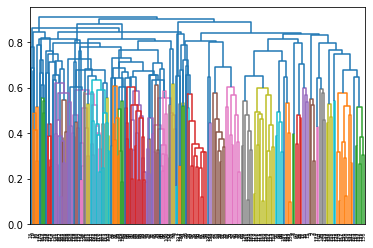

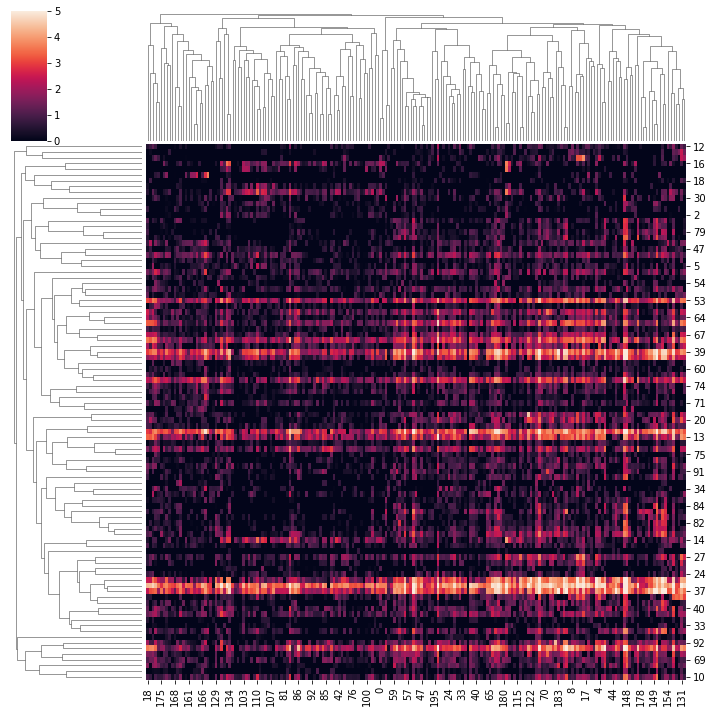

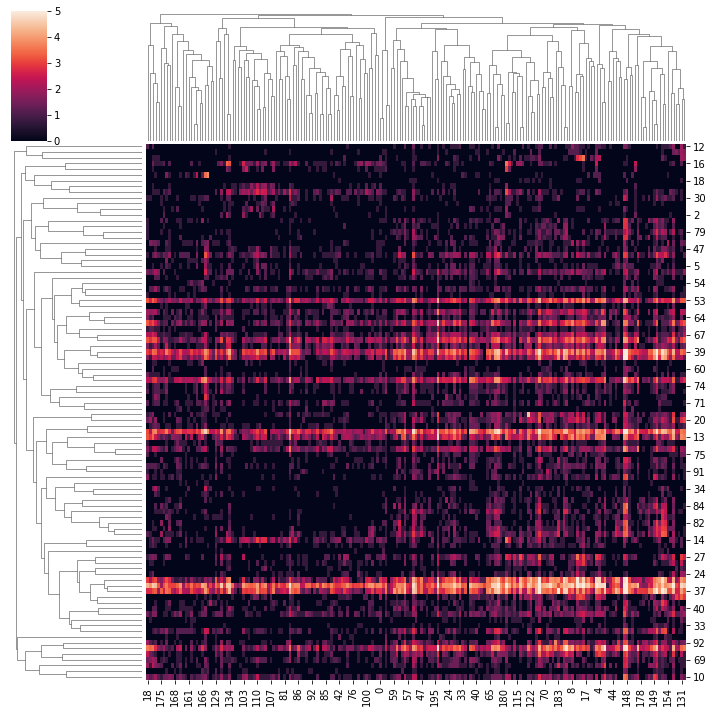

In [6]:
# model = Word2Vec.load("word2vec/fulltext_abstract_phrases3.model")
model = Word2Vec.load("word2vec/fulltext_abstract_new.model")
row_dis=[]
col_dis=[]
for i in range(0,tot_cs+1):
    for j in range(i+1,tot_cs+1):
        row_dis.append(1-model.wv.similarity(dict[i],dict[j]))
        
for i in range(0,tot_medical+1):
    for j in range(i+1,tot_medical+1):
        col_dis.append(1-model.wv.similarity(dict[5000+i],dict[5000+j]))
row_linkage = hc.linkage(row_dis, method='average')
col_linkage= hc.linkage(col_dis, method='average')
row_order = hc.dendrogram(row_linkage)

with open('row_order.txt', 'w') as f:
    for i in range(len(row_order['leaves'])):
        f.write(dict[row_order['leaves'][i]]+'\n')
col_order = hc.dendrogram(col_linkage)
with open('col_order.txt', 'w') as f:
    for i in range(len(col_order['leaves'])):
        f.write(dict[col_order['leaves'][i]+5000]+'\n')

        plot_heat=np.zeros((tot_cs+1,tot_medical+1))
for i in range(0,tot_cs+1):
    for j in range(0,tot_medical+1):
        plot_heat[i][j]=pred_heat[i+20][j+20]
plot_heat=np.log1p(plot_heat)
g=sns.clustermap(plot_heat, row_linkage=row_linkage, col_linkage=col_linkage,vmin=0,vmax=5 ) 
# g.savefig("2019-6-pred_3.pdf")
g.savefig("2022-5-pred_3.pdf")


for i in range(0,tot_cs+1):
    for j in range(0,tot_medical+1):
        plot_heat[i][j]=last_heat[i+20][j+20]
plot_heat=np.log1p(plot_heat)
g=sns.clustermap(plot_heat, row_linkage=row_linkage, col_linkage=col_linkage,vmin=0,vmax=5 ) 
# g.savefig("2019-6-actal_3.pdf")
g.savefig("2022-5-actal_3.pdf")

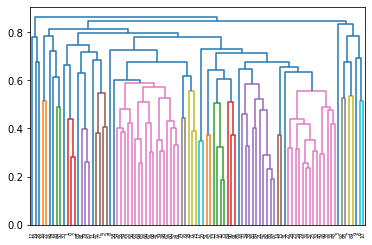

In [9]:
row_order = hc.dendrogram(row_linkage)
row_order.savefig("2022-5-actal_3.pdf")